In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn

from scipy.spatial import distance
import seaborn as sns

/home/co-dutt1/.conda/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def disable_module(module):
    for p in module.parameters():
        p.requires_grad = False
        
def enable_module(module):
    for p in module.parameters():
        p.requires_grad = True


def check_tunable_params(model, verbose=True):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            if(verbose):
                print(name)
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.5f}"
    )

    return trainable_params, all_param

def create_mapping(model, vector):
    mapping = {}
    i = 0

    for name_p,p in model.named_parameters():
        if '.attn.' in name_p or 'attention' in name_p:
            mapping[name_p] = vector[i]
            i += 1
        else:
            p.requires_grad = False
            
    return mapping

def sort_dict(dict, descending=False):
    sorted_dict = dict(sorted(dict.items(), key=lambda item: item[1], reverse=descending))
    
    return sorted_dict

def get_modules_from_vector(vector, model):
    trainable_blocks = []
    frozen_blocks = []
    
    trainable_blocks = np.where(np.array(vector) == 1)
    frozen_blocks = np.where(np.array(vector) == 0)
    
    return trainable_blocks, frozen_blocks

def get_model_for_bitfit(model):
    trainable_components = ['bias', 'pooler.dense.bias', 'head'] 

    # Disale all the gradients
    for param in model.parameters():
        param.requires_grad = False 
      
    vector = []

    for name, param in model.named_parameters():
        for component in trainable_components:
            if component in name:
                vector.append(1)
                param.requires_grad = True
                break
    
    return vector

def enable_from_vector(vector, model):
    print("Vector: ", vector)
    
    disable_module(model)
    
    for idx, block in enumerate(model.blocks): 
    
        if(vector[idx] == 1):
            print("Enabling attention in Block {}".format(idx))
            enable_module(block.attn)
        else:
            #print("Disabling attention in Block {}".format(idx))
            disable_module(block.attn)

def create_best_worst_vectors(df, k=10):
    best_df = df.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
    worst_df = df.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)

    best_vector = np.array([0]*12)

    for i in range(len(best_df)):
        vector_path = best_df['Vector Path'][i]
        vector = np.load(vector_path)
        best_vector += vector

    worst_vector = np.array([0]*12)

    for i in range(len(worst_df)):
        vector_path = worst_df['Vector Path'][i]
        vector = np.load(vector_path)
        worst_vector += vector

    return best_vector, worst_vector

In [8]:
base_path = '/home/co-dutt1/rds/hpc-work/Layer-Masking/'

dataset = 'breastUS'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_blocks_random_' + model + '_0.0001.csv'
df_breastUS = pd.read_csv(csv)

dataset = 'fitzpatrick'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_blocks_random_' + model + '_0.0001.csv'
df_fitzpatrick = pd.read_csv(csv)

dataset = 'HAM10000'
vector_path = '/home/co-dutt1/rds/hpc-work/Layer-Masking/saved_vectors/vit_base/HAM10000/tune_attention_blocks_random_0.0001/'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_blocks_random_' + model + '_0.0001.csv'
df_ham10k = pd.read_csv(csv)
df_ham10k['Vector Path'] = df_ham10k['Vector Path'].apply(lambda x: os.path.join(vector_path, x.split('/')[-1]))

# dataset = 'smdg'
# model = 'vit_base_ssl'
# csv = base_path + model + '/' + dataset + '/tune_attention_blocks_random_' + model + '_0.0001.csv'
# df_smdg = pd.read_csv(csv)

dataset = 'retinopathy'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_blocks_random_' + model + '_0.0001.csv'
df_retinopathy = pd.read_csv(csv)

dataset = 'CIFAR10'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_blocks_random_' + model + '_0.0001.csv'
df_CIFAR10 = pd.read_csv(csv)

# dataset = 'CIFAR100'
# model = 'vit_base_ssl'
# csv = base_path + model + '/' + data~set + '/tune_attention_blocks_random_' + model + '_0.0001.csv'

# df_CIFAR100 = pd.read_csv(csv)

# dataset = 'pneumonia'
# model = 'vit_base_ssl'
# csv = base_path + model + '/' + dataset + '/tune_attention_blocks_random_' + model + '_0.0001.csv'
# df_pneumonia = pd.read_csv(csv)

In [9]:
k = 10

#all_datasets = [df_breastUS, df_fitzpatrick, df_ham10k, df_smdg, df_retinopathy, df_CIFAR10, df_CIFAR100, df_pneumonia]
#all_datasets = [df_breastUS, df_fitzpatrick, df_ham10k, df_smdg, df_retinopathy, df_CIFAR10]
all_datasets = [df_breastUS, df_fitzpatrick, df_ham10k, df_retinopathy, df_CIFAR10]
_best = np.array([0]*12)
_worst = np.array([0]*12)

for df in all_datasets:
    best_vector, worst_vector = create_best_worst_vectors(df)
    _best += best_vector
    _worst += worst_vector

_best

array([30, 26, 29, 23, 27, 27, 21, 32, 25, 22, 27, 31])

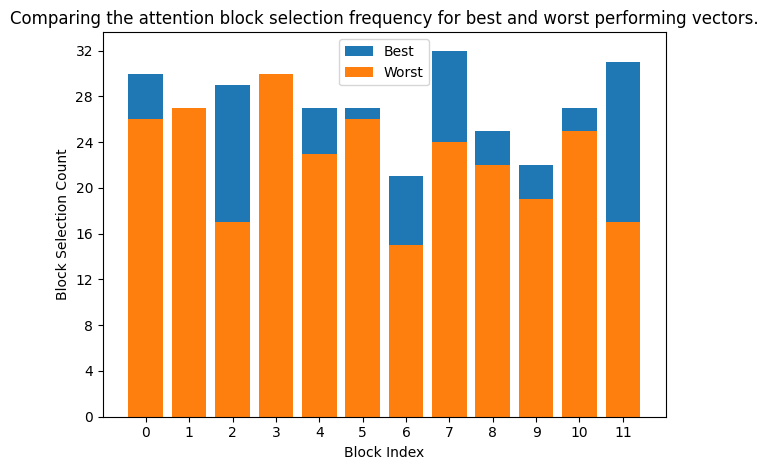

In [10]:
# Creating best and worst vectors for each dataset

indices = np.arange(len(_best))

plt.figsize=(20, 15)
# Plot the bar graph
plt.bar(indices, _best, label='Best')
plt.bar(indices, _worst, label='Worst')
plt.legend()

# Add labels and title
plt.xlabel('Block Index')
plt.ylabel('Block Selection Count')
plt.xticks(list(range(0,12)))
plt.yticks(list(range(0, max(_best)+1, 4)))
plt.title('Comparing the attention block selection frequency for best and worst performing vectors.')

# Show the plot
plt.tight_layout()
plt.savefig("SSL_vit-b_best_worst_block_level.png")